In [1]:
import numpy as np
%matplotlib ipympl
import matplotlib.pyplot as plt
import random

from neurodiffeq.neurodiffeq import safe_diff as diff
from neurodiffeq.networks import FCNN
from neurodiffeq.solvers import Solver1D
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.generators import Generator1D
from neurodiffeq.ode import solve

import torch

In [2]:
a = 0.3; b = 0.5; Q_fpke = 0.25;
def ex1_ode( u, t): 
    return [-(a - 3*b*t**2) - (a*t - b*t**3)*diff(u, t, order = 1) + Q_fpke/2*(diff(u, t, order = 2) + diff(u, t, order = 1)**2) ]


In [3]:
C =  142.88418699042 # normalizing constant
def u_true(x):
    return C*np.exp((1/(2*Q_fpke))*(2*a*x**2 - b*x**4))


In [4]:
from neurodiffeq.conditions import IVP, DirichletBVP

# init_val = [IVP(t_0 = -2.2, u_0 =  np.log(u_true(-2.2)))]
bc_val = [DirichletBVP(t_0 = -2.2, u_0 =  np.log(u_true(-2.2)), t_1=2.2, u_1 = np.log(u_true(2.2)))]

In [5]:
# monitor = Monitor1D(t_min=-2.2, t_max=2.2, check_every=100)
# monitor_callback = monitor.to_callback()

In [6]:
from neurodiffeq.generators import Generator1D

g1 = Generator1D(size=441, t_min= -2.2, t_max=2.2);

In [7]:
nets_ex1 = [FCNN(n_input_units=1, hidden_units=(48, 48), actv=torch.nn.Tanh)];
optimizer = torch.optim.LBFGS(nets_ex1[0].parameters());

In [8]:
# import optim_adahessian
# optimizer = optim_adahessian.Adahessian(nets_ex1[0].parameters())

In [9]:
# solver = Solver1D(ode_system=ex1_ode, t_min=-2.2, t_max=2.2, nets= nets_ex1, conditions=init_val)
solver = Solver1D(ode_system=ex1_ode, t_min=-2.2, t_max=2.2, nets= nets_ex1, conditions=bc_val, train_generator=g1, optimizer=optimizer);
solver.fit(max_epochs=700)#, callbacks = [monitor_callback])
u_pred = solver.get_solution()

Training Progress:   0%|          | 0/700 [00:00<?, ?it/s]

/home/vish0908/anaconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:154: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272128894/work/torch/csrc/autograd/engine.cpp:976.)
  Variable._execution_engine.run_backward(


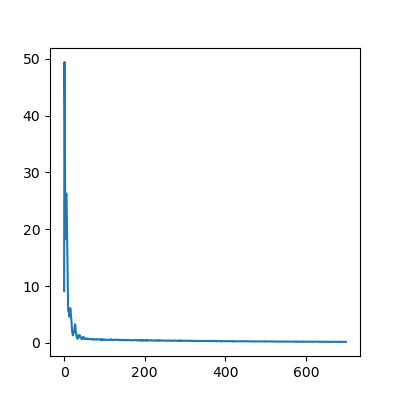

In [10]:
# plot training loss
train_loss = solver.metrics_history['train_loss']
loss_fig = plt.figure(figsize=(4,4))
plt.plot(train_loss, label = 'loss during training')
plt.show()


In [11]:
# integrate over 1d domain
ts = np.linspace(-2.2, 2.2, 100)

import scipy.integrate as integrate
# res = integrate.quad(lambda x: np.exp(u_pred(x)), -2.2, 2.2)  # problematic u_pred function
C_pred = integrate.simpson(np.exp(u_pred(ts, to_numpy = True)), ts)
print(C_pred)

0.00012902231795676239


In [12]:
# compute true and predicted values on domain
u_ts_pred = 1/C_pred*np.exp(u_pred(ts, to_numpy=True))
C_true = integrate.simpson((u_true(ts)), ts)
u_ts_true = 1/C_true*u_true(ts)


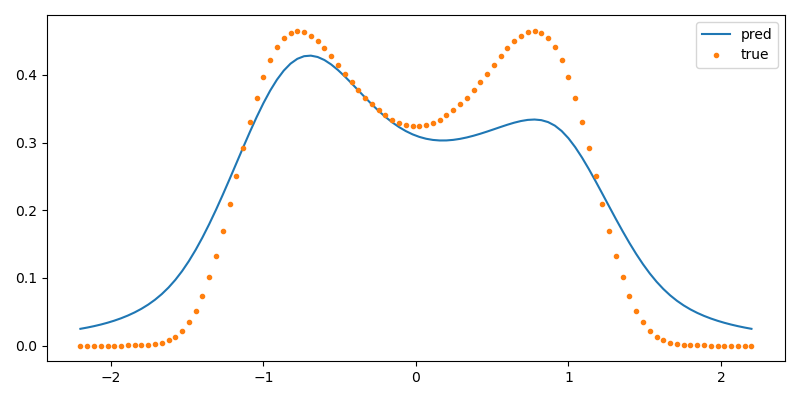

In [13]:
# plot results
fig = plt.figure(figsize=(8,4))
plt.plot(ts, u_ts_pred, label = "pred")
plt.plot(ts, u_ts_true, '.', label = "true")
plt.tight_layout()
plt.legend()
plt.show()

In [14]:
print(np.max(u_ts_pred))

0.42858072236075706
